In [1]:
#计算基本的街道网络措施(拓扑和度量)
import osmnx as ox, networkx as nx, matplotlib.cm as cm, pandas as pd, numpy as np
%matplotlib inline
ox.config(log_file=True, log_console=True, use_cache=True)

In [2]:
#加载Piedmont的OSM道路网络数据，并且计算它的基本度量
#G = ox.graph_from_place('Piedmont, California, USA', network_type='drive_service')
#ox.save_graphml(G,'Piedmont.graphml')
G = ox.load_graphml('Piedmont.graphml')
stats = ox.basic_stats(G)
stats['circuity_avg']

1.1132723245590253

In [3]:
#获取Piedmont的OSM道路网络，并且计算它的面积
place = 'Piedmont, California, USA'
gdf = ox.gdf_from_place(place)
area = ox.project_gdf(gdf).unary_union.area
print(area)

4346476.012557067


In [4]:
#计算基本和扩展的该地区的网络数据，合并它们，并显示出来。
stats = ox.basic_stats(G, area=area)
extended_stats = ox.extended_stats(G, ecc=True, bc=True, cc=True)
for key, value in extended_stats.items():
    stats[key] = value
pd.Series(stats)

avg_neighbor_degree                    {53090322: 3.0, 53090323: 3.3333333333333335, ...
avg_neighbor_degree_avg                                                          2.86917
avg_weighted_neighbor_degree           {53090322: 0.023583786782732718, 53090323: 0.0...
avg_weighted_neighbor_degree_avg                                               0.0333023
betweenness_centrality                 {53090322: 0.13923492955693434, 53090323: 0.07...
betweenness_centrality_avg                                                     0.0378462
center                                                                       [305541020]
circuity_avg                                                                     1.11327
clean_intersection_count                                                            None
clean_intersection_density_km                                                       None
closeness_centrality                   {53090322: 0.0006454727616455616, 53090323: 0....
closeness_centrality_

In [5]:
# 把字典解压缩到相应的键-值对
stats = ox.basic_stats(G, area=area)
for k, count in stats['streets_per_node_counts'].items():
    stats['int_{}_count'.format(k)] = count
for k, proportion in stats['streets_per_node_proportion'].items():
    stats['int_{}_prop'.format(k)] = proportion

# 删除掉不再需要的字典元素
del stats['streets_per_node_counts']
del stats['streets_per_node_proportion']

# 以pandas的dataframe形式加载出来
pd.DataFrame(pd.Series(stats)).T

,circuity_avg,clean_intersection_count,clean_intersection_density_km,edge_density_km,edge_length_avg,edge_length_total,int_0_count,int_0_prop,int_1_count,int_1_prop,...,k_avg,m,n,node_density_km,self_loop_proportion,street_density_km,street_length_avg,street_length_total,street_segments_count,streets_per_node_avg
0,1.113272,NaN,NaN,27128.593397,116.400573,117913.780456,0.0,0.0,46.0,0.121372,...,5.345646,1013.0,379.0,87.197076,0.005923,14099.731842,116.288703,61284.146235,527.0,2.894459


In [6]:
# Inspect betweenness centrality
#G_pro = ox.project_graph(G)
#ox.save_graphml(G,'Piedmontpro.graphml')
G_pro = ox.load_graphml('Piedmontpro.graphml')
max_node, max_bc = max(extended_stats['betweenness_centrality'].items(), key=lambda x: x[1])
max_node, max_bc

(53124805, 0.30011105596595106)

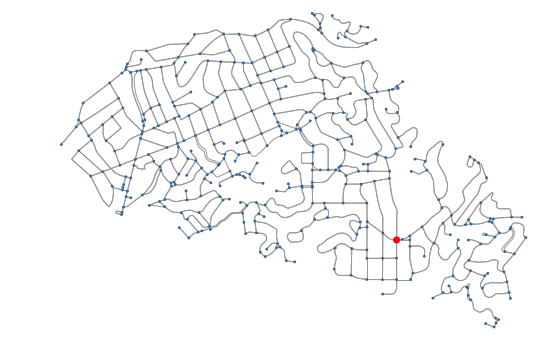

In [7]:
nc = ['r' if node==max_node else '#336699' for node in G_pro.nodes()]
ns = [50 if node==max_node else 8 for node in G_pro.nodes()]
fig, ax = ox.plot_graph(G_pro, node_size=ns, node_color=nc, node_zorder=2)

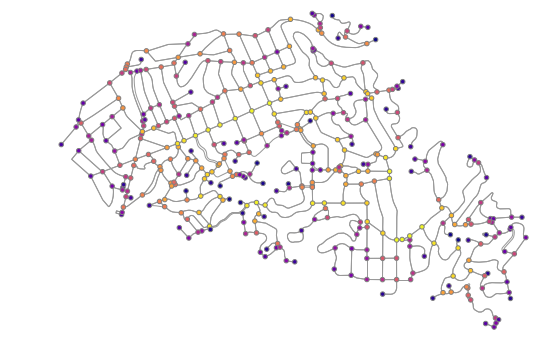

In [8]:
# get a color for each node
#  the nodes are visualized by betweenness centrality, from low (dark violet) to high (light yellow).
def get_color_list(n, color_map='plasma', start=0, end=1):
    return [cm.get_cmap(color_map)(x) for x in np.linspace(start, end, n)]

def get_node_colors_by_stat(G, data, start=0, end=1):
    df = pd.DataFrame(data=pd.Series(data).sort_values(), columns=['value'])
    df['colors'] = get_color_list(len(df), start=start, end=end)
    df = df.reindex(G.nodes())
    return df['colors'].tolist()

nc = get_node_colors_by_stat(G_pro, data=extended_stats['betweenness_centrality'])
fig, ax = ox.plot_graph(G_pro, node_color=nc, node_edgecolor='gray', node_size=20, node_zorder=2)

In [9]:
# node closeness centrality
node_centrality = nx.closeness_centrality(G_pro)

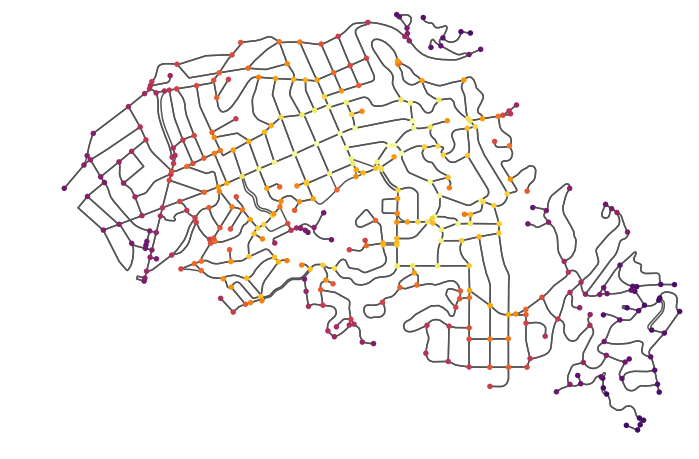

In [10]:
# plot it
df = pd.DataFrame(data=pd.Series(node_centrality).sort_values(), columns=['cc'])
df['colors'] = ox.get_colors(n=len(df), cmap='inferno', start=0.2)
df = df.reindex(G.nodes())
nc = df['colors'].tolist()
fig, ax = ox.plot_graph(G, bgcolor='k', save=True, file_format='svg', filename='picture01',node_size=30, node_color=nc, node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=1.5, edge_alpha=1)